Jan Schmidt (I6079633)

I had a few problems using sklearn on colab. To fix them I had to update scikit on colab.

In [ ]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

In [1]:
import sklearn 
sklearn.__version__

'1.0'

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, RocCurveDisplay

from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression
from sklearn.feature_selection import RFE, SelectFromModel, chi2

from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Master_AI/DataMining/Labs/Lab3/caravan.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Master_AI/DataMining/Labs/Lab3/caravanTest.csv')


scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns = df_train.columns)
df_test_scaled = pd.DataFrame(scaler.fit_transform(df_test), columns = df_test.columns)


Short look into the structure of the datafile.

In [8]:
df_train.head()

,Customer Subtype,Number of houses,Avg size household,Avg Age,Customer main type,Roman catholic,Protestant,Other religion,No religion,Married,Living together,Other relation,Singles,Household without children,Household with children,High level education,Medium level education,Lower level education,High status,Entrepreneur,Farmer,Middle Management,Skilled labourers,Unskilled labourers,Social class A,Social class B1,Social class B2,Social class C,Social class D,Rented house,Home owners,1 car,2 cars,No car,National Health Service,Private health insurance,Income < 30.000,Income 30-45.000,Income 45-75.000,Income 75-122.000,...,Contribution car policies,Contribution delivery van policies,Contribution motorcycle/scooter policies,Contribution lorry policies,Contribution trailer policies,Contribution tractor policies,Contribution agricultural machines policies,Contribution moped policies,Contribution life insurances,Contribution private accident insurance policies,Contribution family accidents insurance policies,Contribution disability insurance policies,Contribution fire policies,Contribution surfboard policies,Contribution boat policies,Contribution bicycle policies,Contribution property insurance policies,Contribution social security insurance policies,Number of private third party insurance,Number of third party insurance (firms),Number of third party insurance (agriculture),Number of car policies,Number of delivery van policies,Number of motorcycle/scooter policies,Number of lorry policies,Number of trailer policies,Number of tractor policies,Number of agricultural machines policies,Number of moped policies,Number of life insurances,Number of private accident insurance policies,Number of family accidents insurance policies,Number of disability insurance policies,Number of re policies,Number of surfboard policies,Number of boat policies,Number of bicycle policies,Number of property insurance policies,Number of social security insurance policies,CARAVAN POLICY
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# **Part A: Feature Selection**

There are different methods to decide whitch features to select.

In [14]:
df_train.columns

Index(['Customer Subtype', 'Number of houses', 'Avg size household', 'Avg Age',
       'Customer main type', 'Roman catholic', 'Protestant', 'Other religion',
       'No religion', 'Married', 'Living together', 'Other relation',
       'Singles', 'Household without children', 'Household with children',
       'High level education', 'Medium level education',
       'Lower level education', 'High status', 'Entrepreneur', 'Farmer',
       'Middle Management', 'Skilled labourers', 'Unskilled labourers',
       'Social class A', 'Social class B1', 'Social class B2',
       'Social class C', 'Social class D', 'Rented house', 'Home owners',
       '1 car', '2 cars', 'No car', 'National Health Service',
       'Private health insurance', 'Income < 30.000', 'Income 30-45.000',
       'Income 45-75.000', 'Income 75-122.000', 'Income >123.000',
       'Average income', 'Purchasing power class',
       'Contribution private third party insurance',
       'Contribution third party insurance (firms

In [4]:
def split_Datato_Xy(data):
  X = data.drop('CARAVAN POLICY' , axis =1)
  y = data['CARAVAN POLICY']
  return X, y

train_X, train_y = split_Datato_Xy(df_train)
test_X, test_y = split_Datato_Xy(df_test)

train_X_scaled, train_y_scaled = split_Datato_Xy(df_train_scaled)
test_X_scaled, test_y_scaled = split_Datato_Xy(df_test_scaled)

In [9]:
vat_selector = VarianceThreshold(1)
vat_selector.fit(train_X,train_y)
train_X.columns[vat_selector.get_support()]

Index(['Customer Subtype', 'Customer main type', 'Roman catholic',
       'Protestant', 'Other religion', 'No religion', 'Married',
       'Other relation', 'Singles', 'Household without children',
       'Household with children', 'High level education',
       'Medium level education', 'Lower level education', 'High status',
       'Farmer', 'Middle Management', 'Skilled labourers',
       'Unskilled labourers', 'Social class A', 'Social class B1',
       'Social class B2', 'Social class C', 'Social class D', 'Rented house',
       'Home owners', '1 car', '2 cars', 'No car', 'National Health Service',
       'Private health insurance', 'Income < 30.000', 'Income 30-45.000',
       'Income 45-75.000', 'Income 75-122.000', 'Average income',
       'Purchasing power class', 'Contribution car policies',
       'Contribution fire policies'],
      dtype='object')

In [7]:
vts_selector = VarianceThreshold(1)
vts_selector.fit(train_X_scaled,train_y_scaled)
train_X_scaled.columns[vts_selector.get_support()]

Index(['Customer Subtype', 'Protestant', 'No religion', 'Married',
       'Household without children', 'High level education', 'High status',
       'Social class C', 'Rented house', 'Income >123.000',
       'Contribution private third party insurance',
       'Contribution trailer policies', 'Contribution life insurances',
       'Contribution disability insurance policies',
       'Contribution fire policies', 'Contribution boat policies',
       'Contribution social security insurance policies',
       'Number of delivery van policies', 'Number of lorry policies',
       'Number of moped policies',
       'Number of private accident insurance policies',
       'Number of family accidents insurance policies',
       'Number of surfboard policies',
       'Number of social security insurance policies'],
      dtype='object')

Using scaled data instead of unscaled date changes the outcome a little bit but without a clear preference to which one is better

For the later Features Selectors I limited the maximum features to 10. This makes it more observable, and as such better understandable

More usable seams to be the SelectKBest selector. I used SKB with mutual info regression as score function.   

In [6]:
skb_selector = SelectKBest(mutual_info_regression, k =10)
skb_selector.fit(train_X, train_y)
X.columns[skb_selector.get_support()]

Index(['Customer main type', 'No religion', 'Married', 'Singles',
       'Lower level education', 'Purchasing power class',
       'Contribution car policies', 'Number of car policies',
       'Number of agricultural machines policies', 'Number of re policies'],
      dtype='object')

In [14]:
skb_selector = SelectKBest(chi2, k =10)
skb_selector.fit(train_X, train_y)
X.columns[skb_selector.get_support()]

Index(['Customer Subtype', 'High level education', 'Rented house',
       'Home owners', 'Contribution car policies',
       'Contribution fire policies', 'Contribution boat policies',
       'Contribution social security insurance policies',
       'Number of car policies', 'Number of boat policies'],
      dtype='object')

Using chi2 as score function give better (more reasonable) features as result

Next I test RFE with Logistic Regression as estimator

In [10]:
rfe_selector = RFE(estimator=LogisticRegression(),n_features_to_select = 10)
rfe_selector.fit(train_X, train_y)
X.columns[rfe_selector.get_support()]

Index(['Farmer', 'Rented house', 'Home owners',
       'Contribution private third party insurance',
       'Contribution agricultural machines policies',
       'Number of private third party insurance', 'Number of moped policies',
       'Number of boat policies', 'Number of bicycle policies',
       'Number of social security insurance policies'],
      dtype='object')

I tried to tweek the REF feature selector by manipulating the steps. With step = 2 came the most interesting results

In [12]:
rfe2_selector = RFE(estimator=LogisticRegression(),n_features_to_select = 10, step = 1)
rfe2_selector.fit(train_X, train_y)
X.columns[rfe2_selector.get_support()]

Index(['Farmer', 'Rented house', 'Home owners',
       'Contribution private third party insurance',
       'Contribution agricultural machines policies',
       'Number of private third party insurance', 'Number of moped policies',
       'Number of boat policies', 'Number of bicycle policies',
       'Number of social security insurance policies'],
      dtype='object')

In [11]:
rfe2_selector = RFE(estimator=LogisticRegression(),n_features_to_select = 10, step = 2)
rfe2_selector.fit(train_X, train_y)
X.columns[rfe2_selector.get_support()]

Index(['Contribution private third party insurance',
       'Contribution lorry policies',
       'Contribution agricultural machines policies',
       'Contribution property insurance policies',
       'Number of private third party insurance', 'Number of moped policies',
       'Number of boat policies', 'Number of bicycle policies',
       'Number of property insurance policies',
       'Number of social security insurance policies'],
      dtype='object')

In [13]:
rfe2_selector = RFE(estimator=LogisticRegression(),n_features_to_select = 10, step = 5)
rfe2_selector.fit(train_X, train_y)
X.columns[rfe2_selector.get_support()]

Index(['Farmer', 'Rented house', 'Contribution private third party insurance',
       'Contribution lorry policies',
       'Contribution agricultural machines policies',
       'Number of private third party insurance', 'Number of re policies',
       'Number of boat policies', 'Number of bicycle policies',
       'Number of social security insurance policies'],
      dtype='object')

Last I tried the Select From Model selector as well with the Logistig regressing as estimator

In [35]:
sfm_selector = SelectFromModel(estimator=LogisticRegression(),max_features = 10)
sfm_selector.fit(train_X, train_y)
X.columns[sfm_selector.get_support()]

Index(['Rented house', 'Home owners', 'National Health Service',
       'Private health insurance',
       'Contribution third party insurance (agriculture)',
       'Contribution boat policies', 'Number of life insurances',
       'Number of re policies', 'Number of boat policies',
       'Number of bicycle policies'],
      dtype='object')

## **Summery:**

The most interesting results came from using the SelectKBest selector, with 'Customer main type', 'Purchasing power class', 'Contribution car policies',
and some other policies being part of the feature pool.

Most feature selectors ended with mostly finacial relavant features or other policies features.

This makes sense as the financial status as well as the the behavior of purchasing policies in general are features a humes has also looked for.



# **Part B: Prediction**

First the given Classifier Pipline is performed to give a baseline

In [8]:
classifier = LogisticRegression()
pipeClassifier = make_pipeline(SelectKBest(chi2, k=4), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=4,
                             score_func=<function chi2 at 0x7ff72c24aef0>)),
                ('logisticregression', LogisticRegression())])

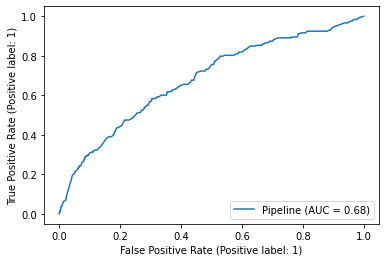

In [9]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

Now I test some of feature selectors used above:

In [15]:
classifier = LogisticRegression()
pipeClassifier = make_pipeline(SelectKBest(chi2, k=10), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function chi2 at 0x7fee358327a0>)),
                ('logisticregression', LogisticRegression())])

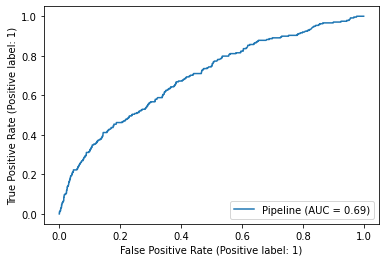

In [16]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

In [17]:
classifier = LogisticRegression()
pipeClassifier = make_pipeline(RFE(estimator=LogisticRegression(),n_features_to_select = 10), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('rfe',
                 RFE(estimator=LogisticRegression(), n_features_to_select=10)),
                ('logisticregression', LogisticRegression())])

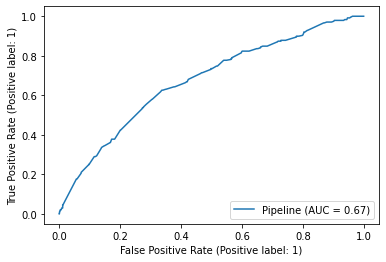

In [18]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

In [19]:
classifier = LogisticRegression()
pipeClassifier = make_pipeline(SelectFromModel(estimator=LogisticRegression(),max_features = 10), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('selectfrommodel',
                 SelectFromModel(estimator=LogisticRegression(),
                                 max_features=10)),
                ('logisticregression', LogisticRegression())])

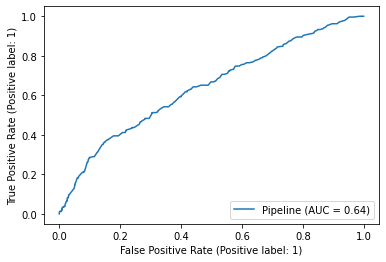

In [20]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

In [21]:
classifier = LogisticRegression()
pipeClassifier = make_pipeline(VarianceThreshold(1), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('variancethreshold', VarianceThreshold(threshold=1)),
                ('logisticregression', LogisticRegression())])

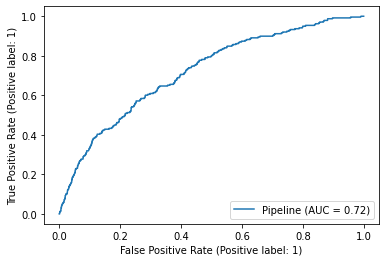

In [22]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

This gives the best AUC (AUC = 7.2). Maby more features increase the results.

I tested the feature selectors with a bigger maximum feature return

In [25]:
classifier = LogisticRegression()
pipeClassifier = make_pipeline(SelectKBest(chi2, k=35), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=35,
                             score_func=<function chi2 at 0x7fee358327a0>)),
                ('logisticregression', LogisticRegression())])

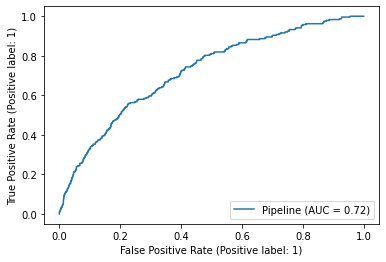

In [26]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

Yes more features improves the AUC.

In [29]:
classifier = LogisticRegression()
pipeClassifier = make_pipeline(SelectKBest(chi2, k=65), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=65,
                             score_func=<function chi2 at 0x7fee358327a0>)),
                ('logisticregression', LogisticRegression())])

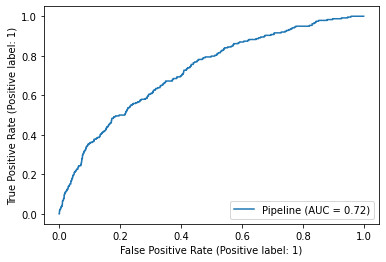

In [30]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

But further increas of the feature size does not give better results

In [27]:
classifier = LogisticRegression()
pipeClassifier = make_pipeline(RFE(estimator=LogisticRegression(),n_features_to_select = 35), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('rfe',
                 RFE(estimator=LogisticRegression(), n_features_to_select=35)),
                ('logisticregression', LogisticRegression())])

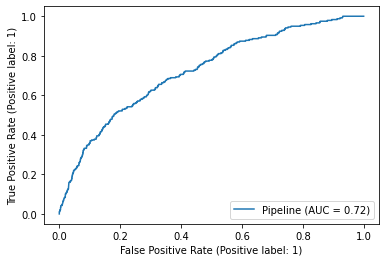

In [28]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

Last I try different classifire in the pipline.

In [31]:
classifier = KNeighborsClassifier()
pipeClassifier = make_pipeline(SelectKBest(chi2, k=35), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=35,
                             score_func=<function chi2 at 0x7fee358327a0>)),
                ('kneighborsclassifier', KNeighborsClassifier())])

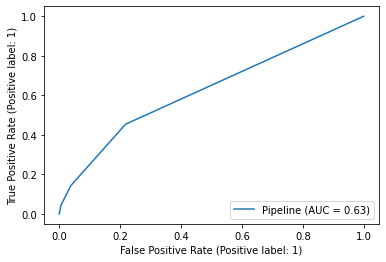

In [32]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

In [33]:
classifier = DecisionTreeClassifier()
pipeClassifier = make_pipeline(SelectKBest(chi2, k=35), classifier)
pipeClassifier.fit(train_X, train_y)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=35,
                             score_func=<function chi2 at 0x7fee358327a0>)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

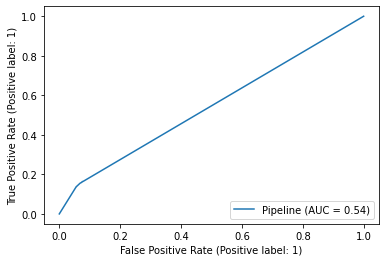

In [34]:
rcd = RocCurveDisplay.from_estimator(pipeClassifier, test_X, test_y)

But their results aren't better

## **Summery:**

The seemingly best return are created by a LogisticRegression Classifier with a SelectKBest(chi2, k=35)feature selector